In [3]:
import quspin as qs
import numpy as np
import matplotlib.pyplot as plt
from quspin.operators import hamiltonian # Hamiltonians and operators
from quspin.basis import spin_basis_1d # Hilbert space spin basis
from quspin.operators import quantum_operator
import math
from quspin.basis import spin_basis_general

In [4]:
def str_tens(A, B):
    new = []
    for i in A:
        for n in B:
            new.append(i + n)
    return new

def up_pop_plot(L, populations, values, dep_var):
    #basis = [r'0', r'1']
    #labels = [r'0', r'1']
    #for i in range(L - 1):
        #labels = str_tens(labels, basis)
    n_rows = len(populations[0])
    n_cols = len(populations[0][0])
    probs = [[matrix[i][j] for matrix in populations] for i in range(n_rows) for j in range(n_cols)]
    values = values*(10**3)    
    fig, axes = plt.subplots(1, 1)
    for i in range(L):
        axes.plot(values, probs[i], label=f'Particle {i+1}')
        
    #for i in range(5):
        #print(populations[:,1][100*i])

    axes.set_ylabel(r"Probability of detecting $\left|1\right>$", fontsize=20)
    axes.set_xlabel(dep_var, fontsize=20)
    axes.legend(loc=1, prop={'size': 14})

    axes.minorticks_on()
    axes.tick_params(which='major', length=10, width=2, direction='in', bottom=True, top=True, left=True, right=True)
    axes.tick_params(which='minor', length=5, width=2, direction='in', bottom=True, top=True, left=True, right=True)
    axes.set_yticks([0, 0.5, 1]) 
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
    plt.savefig(f'{L}_Particle_Spin_Evolution.png', bbox_inches='tight')
    
    plt.show(block=False)

In [5]:
#define pulse sequences
def pulse_ramsey(t, pulse_time, free_time, rabi_frequency):
    if t <= pulse_time:
        return rabi_frequency
    elif t < pulse_time + free_time:
        return 0 
    elif t <= 2 * pulse_time + free_time:
        return rabi_frequency
    else:
        return 0

def pulse_single(t, pulse_time, free_time, rabi_frequency):
    if t <= pulse_time:
        return rabi_frequency
    else:
        return 0

def no_pulse(t, pulse_time, free_time, rabi_frequency):
    return 0

In [6]:
pulse_time = 0.0478e-3 # in s
free_time = 15000 * pulse_time # 0.6e-3 # in s
rabi_frequency = 2*np.pi*(1/pulse_time)/4 # From RbCs Ramsey Paper https://doi.org/10.1088/2058-9565/aaee35 Figure 7
print((pulse_time*rabi_frequency)/(np.pi/2)) # Check pulse time and rabi frequency give a pi/2 pulse area 

0.9999999999999999


In [11]:
L = 2

J = 1000 #Hz
det = 0 #detuning
ax, ay = 1, 1 #lattice seperation in x and y directions  AX MAY BE SET AS AN AXIS LATER RATHER THAN THIS VALUE
row_len = L #Number of sites per row in lattice
params = [pulse_time, free_time, rabi_frequency]

def construct_H(L, J, det, ax, ay, row_len, params, pulse):
    basis = spin_basis_general(N=L, pauli=False)
    #print(basis)
    
    #calculate particle position in lattice
    positions = []
    for i in range(L):
        x = (i % row_len)*ax
        y = (i // row_len)*ay
        positions.append([x, y])
    #print(positions)

    #construct interaction
    sites = range(L)
    pre_int = [[i, k] for idx, i in enumerate(sites) for k in sites[idx + 1:]]
    #interaction strengths between each particle
    intr = []
    for s in pre_int:
        distance = np.sqrt((positions[s[0]][0]-positions[s[1]][0])**2 + (positions[s[0]][1]-positions[s[1]][1])**2)
        intr.append([1/distance**3, s[0], s[1]])

    #construct resonant and detuning terms
    drive = [[1.0, i] for i in range(L)]
    detuning = [[1.0, i] for i in range(L)]

    operator_list_0 = [['z', detuning]]
    operator_list_1 = [['x', drive]]

    #print(intr)

    #construct full Hamiltonian
    interaction = [['+-', intr], ['-+', intr]]
    operator_dict = {'detuning': operator_list_0, 'drive': operator_list_1, 'interaction': interaction}
    H = quantum_operator(operator_dict, basis=basis)
    params_dict = dict(detuning=det, drive=(pulse, params), interaction=J)
    H_lmbda1 = H.tohamiltonian(params_dict)
    return H_lmbda1

H_lmb0 = construct_H(L, J, det, ax, ay, row_len, params, no_pulse)

print(np.array2string(H_lmb0.toarray(), suppress_small=True, formatter={'float': '{:0.4f}'.format}))


Hermiticity check passed!
Symmetry checks passed!
[[   0.+0.j    0.+0.j    0.+0.j    0.+0.j]
 [   0.+0.j    0.+0.j 1000.+0.j    0.+0.j]
 [   0.+0.j 1000.+0.j    0.+0.j    0.+0.j]
 [   0.+0.j    0.+0.j    0.+0.j    0.+0.j]]


Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


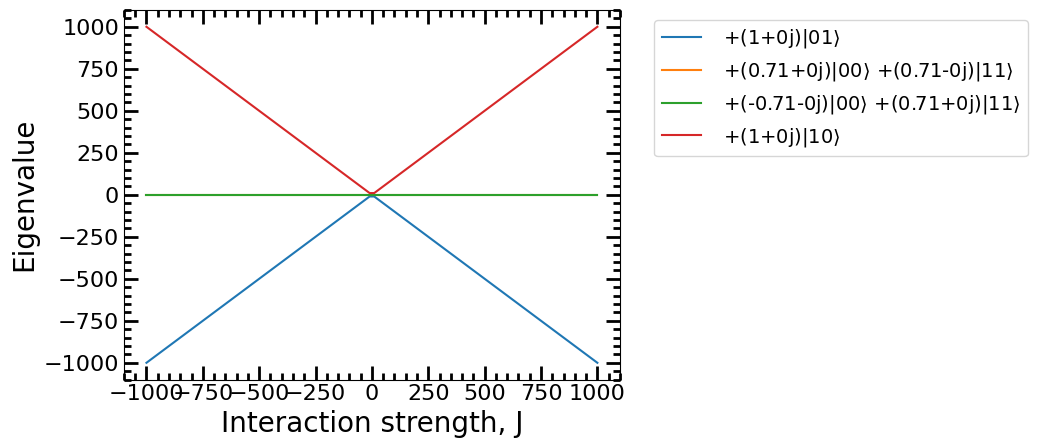

In [13]:
#Computing eigenvalues and eigenvectors
Js = np.linspace(-J, J, 100)
energies = []
for i in Js:
    H_i = construct_H(L, i, det, 1, 1, row_len, params, no_pulse)
    val, vec = H_i.eigh()
    energies.append(val)
    evec = vec

ket = [r'0', r'1']
labels = [r'0', r'1']
for i in range(L - 1):
    labels = str_tens(labels, ket)

fullvec = []
for i in vec:
    count = 0
    lab = ''
    for n in i:
        if n == 0:
            pass
        else:
            print(n)
            print(type('{:.2g}'.format(n)))
            lab = lab + ' +(' + '{:.2g}'.format(n) + ')|' + labels[count] + r'$\rangle$'
            
        count += 1
    fullvec.append(lab)
print(fullvec)

energy = [[matrix[i] for matrix in energies] for i in range(len(energies[0]))]
   
fig, axes = plt.subplots(1, 1)
for i in range(len(fullvec)):
    axes.plot(Js, energy[i], label=fullvec[i])
        
    #for i in range(5):
        #print(populations[:,1][100*i])

axes.set_ylabel(r"Eigenvalue", fontsize=20)
axes.set_xlabel('Interaction strength, J', fontsize=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 14})

axes.minorticks_on()
axes.tick_params(which='major', length=10, width=2, direction='in', bottom=True, top=True, left=True, right=True)
axes.tick_params(which='minor', length=5, width=2, direction='in', bottom=True, top=True, left=True, right=True)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.savefig(f'{L}_Particle_Eigenvectors.png', bbox_inches='tight')
    
plt.show(block=False)

In [192]:
#for labelling graphs
def str_tens(A, B):
    new = []
    for i in A:
        for n in B:
            new.append(i + n)
    return new

In [127]:
rams = False
if rams = True:
    intervals = 150
    holds = np.linspace(0, 300 * pulse_time, intervals)

    psi_0 = np.zeros(2**L)
    psi_0[0] = 1 
    probs = []
    for free_time in holds:
        params = [pulse_time, free_time, rabi_frequency]
        H_lmb = construct_H(L, J, 0, ax, ay, row_len, params, pulse_ramsey)
        times = np.linspace(0, 2*pulse_time + free_time, 10)
        populations = H_lmb.evolve(psi_0, 0, times)
        print(populations[0][-1])
        probs.append([abs(populations[0][-1])**2, abs(populations[1][-1])**2, abs(populations[2][-1])**2, abs(populations[3][-1])**2])


    ket = [r'0', r'1']
    labels = [r'0', r'1']
    for i in range(L - 1):
        labels = str_tens(labels, ket)
    fig, axes = plt.subplots(1, 1)
    for i in range(2**L):
        axes.plot(holds*(10**3), [row[i] for row in probs], label='|' + labels[i] + r'$\rangle$')
        
        #for i in range(5):
            #print(populations[:,1][100*i])

    axes.set_ylabel(r"Probability", fontsize=20)
    axes.set_xlabel('Free evolution time (ms)', fontsize=20)
    axes.legend(loc=1, prop={'size': 14})

    axes.minorticks_on()
    axes.tick_params(which='major', length=10, width=2, direction='in', bottom=True, top=True, left=True, right=True)
    axes.tick_params(which='minor', length=5, width=2, direction='in', bottom=True, top=True, left=True, right=True)
    axes.set_yticks([0, 0.5, 1]) 
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
    plt.savefig(f'{L}_Particle_ramsey.png', bbox_inches='tight')
    
    plt.show(block=False)


SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (3561015171.py, line 2)

In [135]:
intervals = 64
times = np.linspace(0, 1.5, intervals)
psi_0 = np.zeros(2**L)
psi_0[1] = 1  #all spin down
#psi_0[16] = 1  #only middle spin spin up

ket = [r'0', r'1']
labels = [r'0', r'1']
for i in range(L - 1):
    labels = str_tens(labels, ket)
    
populations = H_lmb0.evolve(psi_0, 0, times)
print(len(populations))

#fig, axes = plt.subplots(1, 1)
#for i in range(len(populations)):    
    #axes.plot(times, abs(populations[i])**2, label='|' + labels[i] + r'$\rangle$')
#plt.legend()
#plt.show

32


In [136]:
def up_prob(L, row_len, populations):
    basis = spin_basis_general(N=L, pauli=False)
    col_len = int(math.ceil(L/row_len))

    #contruct outer product of single particle up spin state operator to find the probability it is in up
    outer_products = []
    for i in range(L):
        factors = [[[0.5, i]], [[-1, i]]]
        opers = [['I', factors[0]], ['z', factors[1]]]
        input_dict = {'up': opers}
        outer_products.append(quantum_operator(input_dict, basis=basis))
        #__ = quantum_operator(input_dict, basis=basis).tohamiltonian()
        #print(__.toarray())


    #calculate the probability each particle is spin up for each time evolved
    results = []
    for i in np.transpose(populations):
        probs = np.zeros((col_len, row_len))
        for n in range(L):
            if n==4:
                print(outer_products[n].expt_value(i))
            probs[n//row_len][n%row_len] = outer_products[n].expt_value(i)
        results.append(probs)

    #print(results)
    return results

results = up_prob(L, row_len, populations)
    

Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
(1+0j)
(0.3091791661748358+0j)
(0.21340314412667033+0j)
(0.42402227186299546+0j)
(0.3781835266913921+0j)
(0.17035865286391502+0j)
(0.8450683714619385+0j)
(0.47124471491117126+0j)
(0.08715032512918959+0j)
(0.3836916738766786+0j)
(0.5072597711640949+0j)
(0.15531157033811152+0j)
(0.48801013817350425+0j)
(0.5269735092896328+0j)
(0.0315665664759438+0j)
(0.30232198087446455+0j)
(0.5273203676872317+0j)
(0.2396842956766433+0j)
(0.15683429046354908+0j)
(0.43901094706581556+0j)
(0.03467956287044232+0j)
(0.1906139527609918+0j)
(0.41946931578697816+0j)
(0.30324890632314616+0j)
(0.008332109817462548+0j)
(0.28808376483097053+0j)
(0.0662691232790381+0j)
(0.08001244188476855+0j)
(0.23753744871856222+0j)
(0.25389705862990364+0j)
(0.02330037667543455+0j)
(0.

C:\Users\Joe\AppData\Local\Temp\ipykernel_2376\1076318461.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  probs[n//row_len][n%row_len] = outer_products[n].expt_value(i)


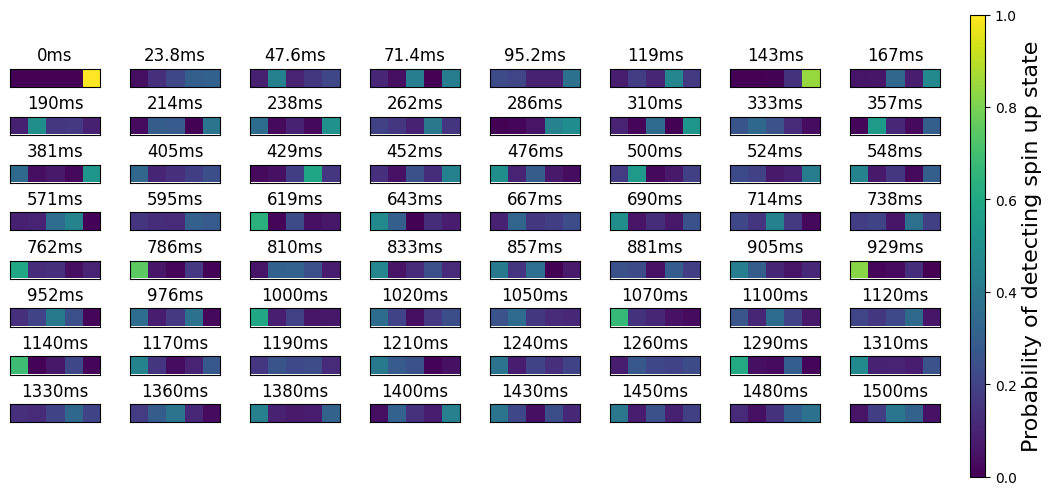

In [137]:
#plot result matricies
from mpl_toolkits.axes_grid1 import ImageGrid

if intervals <= 64:

    dims = int(math.ceil(np.sqrt(len(results))))

    fig = plt.figure(figsize=(1.5*dims, 1.5*dims))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(dims, dims),  # creates grid of Axes
                     axes_pad=0.3,  # pad between Axes in inch.
                     )

    count = 0
    for ax in grid:
        # Iterating over the grid returns the Axes.
        cax = ax.matshow(results[count])
        cax.set_clim(0, 1)
    
        # Hide X and Y axes label marks
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.yaxis.set_tick_params(labelleft=False)

        # Hide X and Y axes tick marks
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title('{:g}'.format(float('{:.3g}'.format(times[count]*(10**3)))) + 'ms')
        count += 1

    cbar = fig.colorbar(cax, location="right", 
            shrink=0.5,
            aspect=30,
            fraction=0.5,
            anchor=(1.1,0.5))

    cbar.ax.set_ylabel('Probability of detecting spin up state', fontsize=16)
    plt.savefig(f'{L}_particles_Arrays_of_spin_probabilities.png', bbox_inches='tight')
    plt.show()
else:
    pass




In [138]:
if intervals >= 100:
    up_pop_plot(L, results, times, 'Evolution time (ms)')

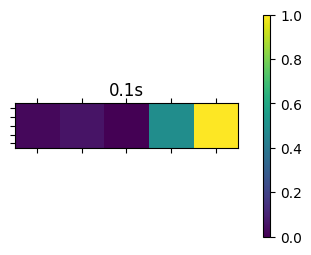

In [351]:
# animation
from matplotlib.animation import PillowWriter

metadata = dict(title='Movie', artist='codinglikemad')
writer = PillowWriter(fps=24, metadata=metadata)

fig, ax = plt.subplots()

ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
ax.set_xticks([])
ax.set_yticks([])


cbar.ax.set_ylabel('Probability of detecting spin up state')

with writer.saving(fig, f'{L}_particle_2D_spin.gif', 100):
    cax = ax.matshow(results[0])
    cax.set_clim(0, 1)
    cbar = fig.colorbar(cax, location="right", 
            shrink=0.6,
            aspect=30,
            fraction=0.5)
    count = 0
    for i in results[0:]:
        ax.clear()
        ax.set_title('{:g}'.format(float('{:.3g}'.format(times[count]))) + 's')
        cax = ax.matshow(i)
        writer.grab_frame()
        count += 1
        
    